In [1]:
from pathlib import Path
import random

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
from models.lfsr import LFSR
from models.pqmf import PQMF

def mtmt(x, lin):
    return lin(x.mT).mT

class Clipper(nn.Module):
    def __init__(self, slope = 2):
        super().__init__()
        self.slope = slope

    def forward(self, x):
        x = self.slope*x
        return torch.clamp(x, -1.0, 1.0)

# if your nonlinearity isn't in the feedback path you should probably just use a linear reservoir tbh
class Abstract_RC(nn.Module):
    def __init__(self, in_dim, nonlin = Clipper(), symbreak=None):
        super().__init__()
        self.in_dim = in_dim
        self.nonlin = nonlin
        self.feature_pushforward = self._gen_weights()
        self.symbreak = symbreak

    def update_feats(self, datavec):
        self.features = self.features.to(datavec.device)
        self.features @= self.feature_pushforward.to(datavec.device)
        self.features = self.features.expand(datavec.shape) + datavec
        self.features = self.nonlin(self.features)

    def forward(self, x, init_feat = None): # x: [batch, vector_dim, time]
        self.features = torch.zeros(x.shape[:-1]) if init_feat is None else init_feat
        out = []
        for i in range(x.shape[-1]):
            self.update_feats(x[..., i])
            out.append(self.features)

        resbuf =  torch.stack(out).movedim(0, -1)
        if self.symbreak is not None:
            resbuf = torch.cat((resbuf, self.symbreak(resbuf)), dim=1)
        return resbuf

class CyclicMultiplex_RC(Abstract_RC):
    def __init__(self, degree, spec_rad=0.1, *args):
        self.degree = degree
        self.spec_rad = spec_rad
        super().__init__(*args)

    def _gen_weights(self):
        cyclemask = sum(torch.eye(self.in_dim).roll(i, dims=0) for i in range(1, self.degree))
        A = torch.randn(self.in_dim, self.in_dim)*cyclemask
        return self.spec_rad * A / torch.linalg.eigvals(A)[0].abs()

class LowBit_RC(CyclicMultiplex_RC):
    def __init__(self, n_bits, seed = 69, *args):
        self.n_bits = n_bits
        self.seed = seed

        super().__init__(*args)

    def _gen_weights(self):
        cyclemask = sum(torch.eye(self.in_dim).roll(i, dims=0) for i in range(1, self.degree)).bool()

        lfsr = LFSR(seed = self.seed)
        A = torch.zeros(self.in_dim, self.in_dim)
        A[cyclemask] = torch.tensor([lfsr.gen_fxp_shift(self.n_bits) for _ in range(cyclemask.sum())])

        if self.spec_rad > 0:
            return self.spec_rad * A / torch.linalg.eigvals(A)[0].abs()

        return A

In [4]:
def reluleak128(x):
    return F.leaky_relu(x, 1.0/128)

class Pipeline(nn.Module):
    def __init__(self, bands, bits, spec_rad, plex, seed=69):
        super().__init__()
        self.in_norm = nn.InstanceNorm1d(bands)
        
        rc_nl =  Clipper(slope=4)
        self.rc = LowBit_RC(bits, seed, 
                            plex, spec_rad, 
                            bands, 
                            rc_nl, reluleak128)
        
        self.ff1 = nn.Linear(bands, 3*bands)
        self.ff2 = nn.Linear(3*bands, 2*bands)

        allfeats = 6*bands
        self.lin_out = nn.Linear(allfeats, 11)

        self.preact_norm = nn.BatchNorm1d(11)

    def forward(self, x):
        nbands = self.in_norm(x)

        nl_tdyn = self.rc(nbands)

        ff = reluleak128(mtmt(reluleak128(mtmt(nbands, self.ff1)), self.ff2))
        
        stacked = torch.cat((x, nbands, 
                             ff, nl_tdyn), dim=1)

        assimilated = reluleak128(self.preact_norm(mtmt(stacked, self.lin_out)))

        return  assimilated.mean(dim=-1)

In [5]:
paramdict = {'bands': 8, 'bits': 4, 'spec_rad': 0.1, 'plex': 8}
uut = Pipeline(**paramdict).cuda()

def load_model(m, folder, device='cuda'):
    ckpt_path = Path(folder)
    fnames = [f.name for f in ckpt_path.iterdir() if f.is_file()]
    fpnames = [n.split(".ten")[0] for n in fnames]
    print(ckpt_path, "\n", fnames, "\n",fpnames)
    print("targeting", [n for n, _ in m.named_parameters()])
    epoch = int(folder.split("epoch")[-1])
    for pname, p in m.named_parameters():
        assert (
            pname in fpnames
        ), f"Unable to locate parameter {pname} in given checkpoint dir"
        loaded = torch.load(ckpt_path / fnames[fpnames.index(pname)]).to(device)
        print("setting", pname, "to loaded value from", fnames[fpnames.index(pname)])
        prev = p.data.clone().detach()
        p.data = loaded
        # print("diff", (p - prev).abs().sum())

    return epoch

/net/flood/home/theloni/audio-rc-rtl/exploration/models/lfsr.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.poly_degrees = torch.tensor(polydegrees)


In [6]:
with torch.no_grad():
    load_model(uut, "models/rc8.3/epoch299")
uut.eval()

models/rc8.3/epoch299 
 ['ff1.bias.tensor', 'ff1.weight.tensor', 'ff2.bias.tensor', 'ff2.weight.tensor', 'lin_out.bias.tensor', 'lin_out.weight.tensor', 'preact_norm.bias.tensor', 'preact_norm.weight.tensor'] 
 ['ff1.bias', 'ff1.weight', 'ff2.bias', 'ff2.weight', 'lin_out.bias', 'lin_out.weight', 'preact_norm.bias', 'preact_norm.weight']
targeting ['ff1.weight', 'ff1.bias', 'ff2.weight', 'ff2.bias', 'lin_out.weight', 'lin_out.bias', 'preact_norm.weight', 'preact_norm.bias']
setting ff1.weight to loaded value from ff1.weight.tensor
setting ff1.bias to loaded value from ff1.bias.tensor
setting ff2.weight to loaded value from ff2.weight.tensor
setting ff2.bias to loaded value from ff2.bias.tensor
setting lin_out.weight to loaded value from lin_out.weight.tensor
setting lin_out.bias to loaded value from lin_out.bias.tensor
setting preact_norm.weight to loaded value from preact_norm.weight.tensor
setting preact_norm.bias to loaded value from preact_norm.bias.tensor


Pipeline(
  (in_norm): InstanceNorm1d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (rc): LowBit_RC(
    (nonlin): Clipper()
  )
  (ff1): Linear(in_features=8, out_features=24, bias=True)
  (ff2): Linear(in_features=24, out_features=16, bias=True)
  (lin_out): Linear(in_features=48, out_features=11, bias=True)
  (preact_norm): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [7]:
torch.linalg.eigvals(uut.rc.feature_pushforward).abs()

tensor([0.1000, 0.1000, 0.0798, 0.0798, 0.0524, 0.0524, 0.0458, 0.0027])

In [8]:
uut, [(n,p.data) for n,p in uut.named_parameters()], [(n,b.data) for n,b in uut.named_buffers()], 

(Pipeline(
   (in_norm): InstanceNorm1d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
   (rc): LowBit_RC(
     (nonlin): Clipper()
   )
   (ff1): Linear(in_features=8, out_features=24, bias=True)
   (ff2): Linear(in_features=24, out_features=16, bias=True)
   (lin_out): Linear(in_features=48, out_features=11, bias=True)
   (preact_norm): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 [('ff1.weight',
   tensor([[-2.1504e-02,  1.2400e-01, -7.6970e-01,  4.4548e+00, -1.1558e-01,
            -1.1768e-02, -6.2711e-01, -6.5044e-01],
           [ 9.7532e-01,  2.2537e-01,  1.2142e+00, -1.7328e+00,  1.8067e-01,
            -8.9448e-01, -1.5824e+00, -4.7276e-01],
           [ 4.5275e-02,  1.1039e-02, -2.5860e-01,  1.1913e-01,  5.9513e-01,
            -1.1426e+00, -3.8887e+00, -1.5814e-01],
           [ 2.7645e+00, -2.8629e-01, -4.1546e-01, -2.1212e-01, -3.0485e-01,
            -7.4737e-01, -6.2485e-01,  4.9044e-01],
           [ 4.4505e

In [9]:
import warnings
from data.augmentations.randphase import AllPassFilter
from torch_audiomentations import *

with warnings.catch_warnings(action="ignore"):
    # Initialize augmentation callable
    audio_augmentation = Compose(
        transforms=[
            AllPassFilter(sample_rate=8000, p=0.5, output_type="dict"),
            PitchShift(
                max_transpose_semitones=2, p=0.1, sample_rate=8000, output_type="dict"
            ),
            AddColoredNoise(
                p=0.5,
                min_snr_in_db=2,
                max_snr_in_db=15,
                sample_rate=8000,
                output_type="dict",
            ),
            Shift(0.05, 0.33, p=0.1, sample_rate=8000, output_type="dict"),
        ],
        output_type="dict",
    )

In [10]:
from data.torchfsdd.dataset import TorchFSDDGenerator
pqmf = PQMF(100, 8)
# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(
    version="local",
    path="/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings",
    val_transforms=pqmf#lambda x: pqmf(audio_augmentation(x)["samples"]),
)
dset = fsdd.full()
b_rms = lambda x: x.pow(2).mean(dim=-1).mean(dim=-1).sqrt()
NOISE_PROB = 1 / 11
def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences, labels = [], torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        labels[i] = label
        seq = sequence
        dice = random.random()
        if dice < NOISE_PROB:
            labels[i] = 10
            seq = pqmf(
                b_rms(seq).unsqueeze(-1).unsqueeze(-1)
                * torch.randn(seq.shape[0], 1, pqmf.n_band * seq.shape[-1])
            )
        sequences.append(seq)

    # Combine sequences into a padded matrix
    stacked_sequences = torch.cat(
        sequences, dim=0
    )  # torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x T_max x D)

    return stacked_sequences, labels


import torch.utils.data as data_utils
loader = data_utils.DataLoader(
        dset, collate_fn=collate_fn, batch_size=64
    )

In [11]:
X, y = next(iter(loader))
X, y = X.cuda(), y.cuda()
X.shape, y.shape

(torch.Size([64, 8, 1024]), torch.Size([64]))

In [12]:
y

tensor([ 0,  6,  2,  7, 10,  5,  1,  0,  9,  1,  9,  9,  3,  6,  6,  7,  2,  4,
         0,  5,  7, 10,  6,  7,  6,  9,  7,  6,  8,  1,  1, 10,  8,  1,  0,  4,
         4,  7, 10,  8,  0,  4,  8,  4,  6,  4,  6,  3,  7,  3, 10,  5,  4,  9,
         5,  7,  5,  0,  5,  6,  4,  0,  1,  8], device='cuda:0')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

pltr = lambda x: x.cpu().detach().numpy()

In [14]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = pltr(waveform)

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = pltr(waveform)

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate, NFFT=128, noverlap=64)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = pltr(waveform)

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


In [15]:
import random
tidx = random.randint(10, 60)
xtest = pqmf.cuda().inverse(X[tidx].unsqueeze(0))[0]

/net/flood/home/theloni/audio-rc-rtl/exploration/models/pqmf.py:128: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  x = nn.functional.conv1d(x, hk, padding=int(pad))[..., :-1] * m


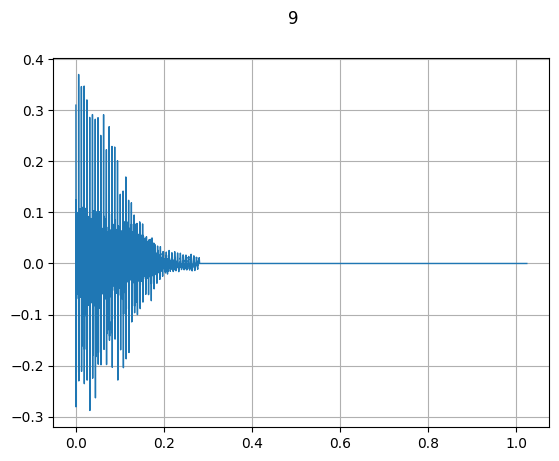

/home/theloni/miniconda/envs/iir-torch/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7944: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


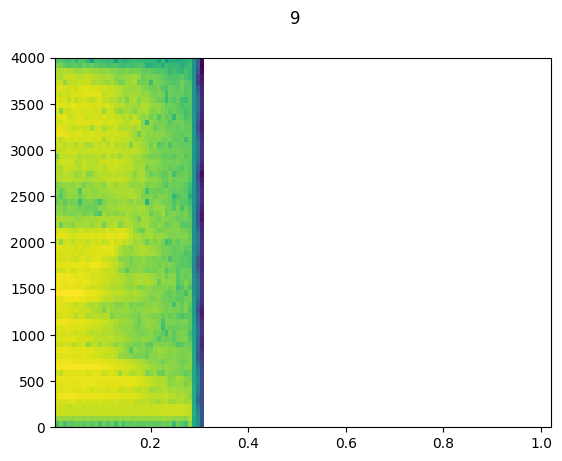

In [16]:
label = y[tidx]
sample_rate = 8000
plot_waveform(xtest, sample_rate, title=label.item())
plot_specgram(xtest, sample_rate, title=label.item())
play_audio(xtest, sample_rate)

In [18]:
yhat = None
acc = []
batches=0
Xs,ys,yhats=[],[],[]
for X, y in loader:
    X, y = X.cuda(), y.cuda()
    Xs.append(X)
    ys.append(y)
    yhat = uut(X)
    yhats.append(yhat)
    acc.append((yhat.argmax(-1) == y).sum() / y.numel())
    batches+=1
sum(acc)/batches

tensor(0.8147, device='cuda:0')

In [19]:
X, y, yhat = map(torch.cat, (Xs, ys, yhats))

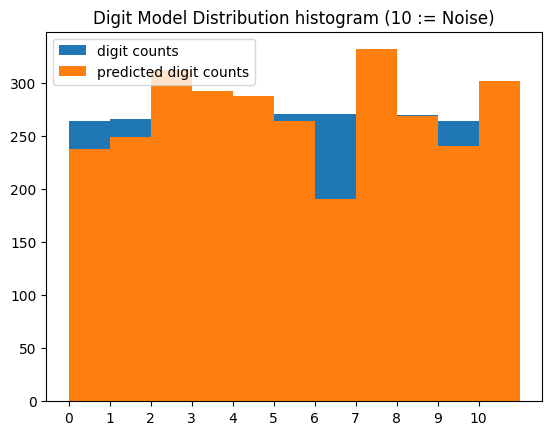

In [20]:
f, ax = plt.subplots()

ax.set_title("Digit Model Distribution histogram (10 := Noise)")
ax.hist(pltr(y.flatten()), bins=np.arange(0, 11 + 1, 1), label="digit counts")
ax.hist(
        pltr(yhat.argmax(1).flatten()), bins=np.arange(0, 11 + 1, 1), label="predicted digit counts"
    )
ax.set_xticks(list(map(float, range(11))))
ax.legend()
plt.show()

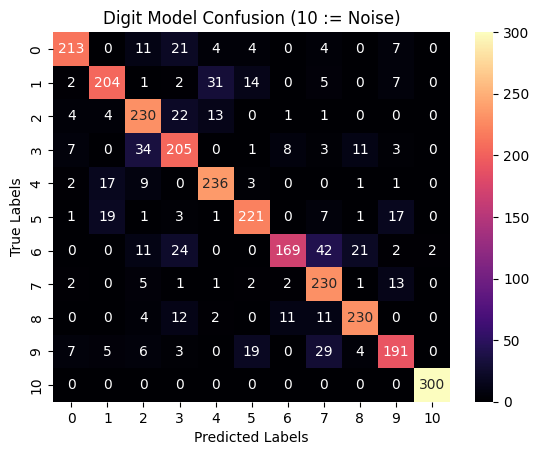

In [22]:
pred = pltr(yhat.argmax(1).flatten())
# Compute confusion matrix
cm = confusion_matrix(pltr(y.flatten()), pred)

# Plot confusion matrix
f, ax = plt.subplots()
ax.set_title("Digit Model Confusion (10 := Noise)")

sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="magma",
        xticklabels=np.unique(pltr(y)),
        yticklabels=np.unique(pltr(y)),
        ax=ax,
)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

plt.show()